In [1]:
import torch
import numpy as np
from tqdm import tqdm

In [2]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [3]:
class mytorch:
    model_step = []
    w = []
    b = []
    step_parameter = []
    
    def __init__(self, classes):
        device = (
            "cuda" if torch.cuda.is_available()
            else "mps" if torch.backends.mps.is_available() 
            else "cpu"
            )
        self.device = device
        self.classes = classes.to(device)
        
    def build_conv_1d(self, out_channels, kernel_size, stride=1, padding=0):
        w = torch.rand((out_channels, kernel_size), device=self.device)
        b = torch.rand(1, device=self.device)
        self.w.append(w)
        self.b.append(b)
        self.model_step.append("conv_1d")
        self.step_parameter.append([out_channels, kernel_size, stride, padding])
    def build_conv_2d(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        w = torch.randn((out_channels, in_channels, kernel_size, kernel_size), device=self.device)
        b = torch.randn(out_channels, device=self.device)
        self.w.append(w)
        self.b.append(b)
        self.model_step.append("conv_2d")
        self.step_parameter.append([in_channels, out_channels, kernel_size, stride, padding])
    def build_NN(self, in_size, out_size):
        w = torch.randn((out_size, in_size), device=self.device)
        b = torch.randn(len(w), device=self.device)
        self.w.append(w)
        self.b.append(b)
        self.model_step.append("NN")
        self.step_parameter.append([])
        
    def build_MeanPool_2d(self, kernel_size, stride=1):
        self.w.append(0)
        self.b.append(0)
        self.model_step.append("MeanPool_2d")
        self.step_parameter.append([kernel_size, stride])
    def build_MaxPool_2d(self, kernel_size, stride=1):
        self.w.append(0)
        self.b.append(0)
        self.model_step.append("MaxPool_2d")
        self.step_parameter.append([kernel_size, stride, 0])
        
    def build_flatten(self):
        self.w.append(0)
        self.b.append(0)
        self.model_step.append("flatten")
        self.step_parameter.append([])
    def build_ReLu(self):
        self.w.append(0)
        self.b.append(0)
        self.model_step.append("ReLu")
        self.step_parameter.append([])
    def build_sigmoid(self):
        self.w.append(0)
        self.b.append(0)
        self.model_step.append("sigmoid")
        self.step_parameter.append([])
    def build_tanh(self):
        self.w.append(0)
        self.b.append(0)
        self.model_step.append("tanh")
        self.step_parameter.append([])
    
    
    def up_sampling_1d(self, X, k=2):
        X = X.to(self.device)
        X = torch.atleast_2d(X)
        y = torch.zeros((len(X), len(X.T)*k-(k-1)), device=self.device)
        for d in range(len(X)):
            for i in range(len(X[d])):
                y[d][i*k] = X[d][i]
        return y
    def down_sampling_1d(self, X, k=2):
        X = X.to(self.device)
        X = torch.atleast_2d(X)
        y = torch.zeros((len(X), int((len(X.T)-1)/k+1)), device=self.device)
        for d in range(len(X)):
            for i in range(len(y[d])):
                y[d][i] = X[d][i*k]
        return y
    def up_sampling_2d(self, X, k=2):
        X = X.to(self.device)
        X = torch.permute(torch.atleast_3d(X), (2, 0, 1)) if X.ndim == 2 else X
        y = torch.zeros((len(X), len(X[0])*k-(k-1), len(X[0].T)*k-(k-1)), device=self.device)
        for d in range(len(X)):
            for i in range(len(X[d])):
                for j in range(len(X[d].T)):
                    y[d][i*k][j*k] = X[d][i][j]
        return y
    def down_sampling_2d(self, X, k=2):
        X = X.to(self.device)
        X = torch.permute(torch.atleast_3d(X), (2, 0, 1)) if X.ndim == 2 else X
        y = torch.zeros((len(X), int((len(X[0])-1)/k+1), int((len(X[0].T)-1)/k+1)), device=self.device)
        for d in range(len(X)):
            for i in range(len(y[d])):
                for j in range(len(y[d].T)):
                    y[d][i][j] = X[d][i*k][j*k]
        return y
    def padding_1d(self, X, padding=0):
        X = X.to(self.device)
        X = torch.atleast_2d(X)
        Y = torch.zeros((len(X), len(X.T)+padding*2), device=self.device)
        for d in range(len(X)):
            for i in range(len(X.T)):
                Y[d][i+padding] = X[d][i]
        return Y
    def padding_2d(self, X, padding=0):
        X = X.to(self.device)
        X = torch.permute(torch.atleast_3d(X), (2, 0, 1)) if X.ndim == 2 else X
        Y = torch.zeros((len(X), len(X[0])+padding*2, len(X[0].T)+padding*2), device=self.device)
        for d in range(len(X)):
            for i in range(len(X[0])):
                for j in range(len(X[0].T)):
                    Y[d][i+padding][j+padding] = X[d][i][j]
        return Y
    
    """
    def conv_1d(self, X, w, b, parameters, *arg):
        out_channels, kernel_size, stride, padding = parameters
        X = X.to(self.device)
        X = torch.atleast_2d(X)
        X = self.padding_1d(X, padding=padding)
        Y = torch.zeros((out_channels, int((len(X.T)-kernel_size)/stride+1)), device=self.device)
        for d in range(len(Y)):
            for c in range(len(X)):
                for i in range(len(Y.T)):
                    Y[d][i] += torch.sum(X[c][stride*i:stride*i+len(w[d])]*w[d])
            Y[d] += b
        return Y
    """
    def conv_2d(self, X, w, b, parameters, index, *arg): 
        in_channels, out_channels, kernel_size, stride, padding = parameters
        X = X.to(self.device)
        X = torch.permute(torch.atleast_3d(X), (2, 0, 1)) if X.ndim == 2 else X
        X = self.padding_2d(X, padding=padding)
        Y = torch.zeros((out_channels, int((len(X[0])-kernel_size)/stride+1), int((len(X[0].T)-kernel_size)/stride+1)), device=self.device)
        for d in range(len(Y)):
            for c in range(len(X)):
                for i in range(len(Y[d])):
                    for j in range(len(Y[d].T)):
                        Y[d][i][j] += torch.sum(X[c][stride*i:stride*i+len(w[d][c]), stride*j:stride*j+len(w[d][c].T)]*w[d][c])
            Y[d] += b[d]
        return Y
    def NN(self, X, w, b, *arg):
        X = X.to(self.device)
        X = torch.atleast_2d(X).T if X.dim==1 else X
        y = torch.zeros(len(X), device=self.device)
        y = torch.matmul(w, X) + b
        return y
    def flatten(self, X, *arg):
        X = X.to(self.device)
        self.step_parameter[arg[-1]] = X.shape
        return X.flatten()
    def MeanPool_2d(self, X, *arg):
        kernel_size, stride = arg[-2]
        X = X.to(self.device)
        X = torch.permute(torch.atleast_3d(X), (2, 0, 1)) if X.ndim == 2 else X
        Y = torch.zeros((len(X), int((len(X[0])-kernel_size)/stride+1), int((len(X[0].T)-kernel_size)/stride+1)), device=self.device)
        w = torch.ones((kernel_size, kernel_size), device=self.device)*(1/kernel_size**2)
        for c in range(len(Y)):
            for i in range(len(Y[c])):
                for j in range(len(Y[c].T)):
                    Y[c][i][j] = torch.sum(X[c][stride*i:stride*i+len(w), stride*j:stride*j+len(w.T)]*w)
        return Y
    def MaxPool_2d(self, X, *arg):
        kernel_size, stride, _ = arg[-2]
        index = arg[-1]
        X = X.to(self.device)
        X = torch.permute(torch.atleast_3d(X), (2, 0, 1)) if X.ndim == 2 else X
        Y = torch.zeros((len(X), int((len(X[0])-kernel_size)/stride+1), int((len(X[0].T)-kernel_size)/stride+1)), device=self.device)
        MaxIndex = torch.zeros((len(Y), len(Y[0]), len(Y[0].T), 2), device=self.device)
        for c in range(len(Y)):
            for i in range(len(Y[c])):
                for j in range(len(Y[c].T)):
                    temp = X[c][stride*i:stride*i+kernel_size, stride*j:stride*j+kernel_size]
                    Y[c][i][j] = torch.max(temp)
                    MaxIndex[c][i][j] = torch.tensor([stride*i+int(torch.floor(torch.argmax(temp)/len(temp[0]))), stride*j+(torch.argmax(temp)%len(temp[0]))], device=self.device)
        self.step_parameter[index][2] = MaxIndex
        return Y
    
    def up_dim(self, dLda, index):
        if dLda.ndim == self.y[index].ndim:
            y = self.y[index]
        elif dLda.ndim > self.y[index].ndim:
            if self.y[index].ndim == 1:
                y = torch.atleast_2d(self.y[index]).T
            elif self.y[index].ndim == 2:
                y = torch.permute(torch.atleast_3d(self.y[index]), (2, 0, 1))
        else:
            raise ValueError()
        return y
    
    def ReLu(self, X, *arg):
        X = X.to(self.device)
        return torch.where(X>0, X, 0)
    def ReLu_backward(self, dLda, index, *arg):
        dLda = dLda.to(self.device)
        y = self.up_dim(dLda, index)
        dLda = torch.multiply(torch.where(y>0, 1, 0), dLda)
        return dLda, 0, 0
    def sigmoid(self, X, *arg):
        X = X.to(self.device)
        return 1/(1 + torch.exp(-X))
    def sigmoid_backward(self, dLda, index, *arg):
        dLda = dLda.to(self.device)
        y = self.up_dim(dLda, index)
        dLda = torch.multiply(torch.exp(-y)/torch.pow(1 + torch.exp(-y), 2), dLda)
        return dLda, 0, 0
    def tanh(self, X, *arg):
        X = X.to(self.device)
        return torch.tanh(X)
    def tanh_backward(self, dLda, index, *arg):
        dLda = dLda.to(self.device)
        y = self.up_dim(dLda, index)
        dLda = torch.multiply(1 - torch.pow(torch.tanh(y), 2), dLda)
        return dLda, 0, 0
    def sign(self, X, mode=0):
        X = X.to(self.device)
        return torch.where(X>0, 1, 0) if mode==0 else torch.where(X>=0, 1, -1) 
    def MSE(self, y, y_pred):
        y = y.to(self.device)
        y_pred = y_pred.to(self.device)
        return 0.5 * torch.pow(y-y_pred, 2)
    def MSE_backward(self, y, y_pred):
        y = y.to(self.device)
        y_pred = y_pred.to(self.device)
        return y_pred-y
        
    def NN_backward(self, dLda, index, *arg):
        dLdw = torch.kron(dLda, self.y[index-1])
        dLdb = dLda.T[0]
        dLda = torch.matmul(self.w[index].T, dLda)
        return dLda, dLdw, dLdb
    def flatten_backward(self, dLda, index, *arg):
        dLda = dLda.to(self.device)
        return dLda.reshape(self.step_parameter[index]), 0, 0
    def conv_2d_backward(self, dLda, index, *arg):
        in_channels, out_channels, kernel_size, stride, padding = arg[0]
        A = torch.permute(torch.atleast_3d(self.y[index-1]), (2, 0, 1)) if self.y[index-1].ndim == 2 else self.y[index-1]
        dLdz = self.up_sampling_2d(dLda, stride)
        dLdb = torch.sum(dLdz, dim=(1, 2))
        dLdw = torch.zeros((out_channels, in_channels, kernel_size, kernel_size), device=self.device)
        for d in range(out_channels):
            for c in range(in_channels):
                for i in range(len(dLdw[d][c])):
                    for j in range(len(dLdw[d][c].T)):
                        dLdw[d][c][i][j] = torch.sum(A[c][i:i+len(dLdz[d]), j:j+len(dLdz[d].T)]*dLdz[d])
        
        dLdz = self.padding_2d(dLdz, kernel_size-1)
        dLdz = torch.broadcast_to(dLdz, (in_channels, out_channels, len(dLdz[0]), len(dLdz[0].T)))
        w = torch.flip(self.w[index], dims=(2, 3))
        dLda = torch.zeros((A.shape), device=self.device)
        
        for c in range(in_channels):
            for d in range(out_channels):
                for i in range(len(dLda[c])):
                    for j in range(len(dLda[c].T)):
                        dLda[c][i][j] += torch.sum(dLdz[c][d][i:i+len(w[d][c]), j:j+len(w[d][c].T)]*w[d][c])
        return dLda, dLdw, dLdb
    def MeanPool_2d_backward(self, dLda, index, *arg):
        kernel_size, stride = arg[0]
        dLdz = torch.permute(torch.atleast_3d(dLda), (2, 0, 1)) if dLda.ndim == 2 else dLda
        dLdz = self.up_sampling_2d(dLdz, stride)
        dLdz = self.padding_2d(dLdz, kernel_size-1)
        dLda = torch.zeros((len(dLdz), int((len(dLdz[0])-kernel_size)+1), int((len(dLdz[0].T)-kernel_size)+1)), device=self.device)
        w = torch.ones((kernel_size, kernel_size), device=self.device)*(1/kernel_size**2)
        for c in range(len(dLda)):
            for i in range(len(dLda[c])):
                for j in range(len(dLda[c].T)):
                    dLda[c][i][j] = torch.sum(dLdz[c][i:i+len(w), j:j+len(w.T)]*w)
        return dLda, 0, 0
    def MaxPool_2d_backward(self, dLda, index, *arg):
        kernel_size, stride, MaxIndex = arg[0]
        dLdz = torch.permute(torch.atleast_3d(dLda), (2, 0, 1)) if dLda.ndim == 2 else dLda
        dLda = torch.zeros((self.y[index-1].shape), device=self.device)
        for c in range(len(dLdz)):
            for i in range(len(dLdz[c])):
                for j in range(len(dLdz[c].T)):
                    dLda[c][int(MaxIndex[c][i][j][0])][int(MaxIndex[c][i][j][1])] += dLdz[c][i][j]
        return dLda, 0, 0
    
    def pred(self, X, return_probability=False):
        X = X.to(self.device)
        y = [X]
        for i in range(len(self.model_step)):
            y.append(getattr(self, self.model_step[i])(y[i], self.w[i], self.b[i], self.step_parameter[i], i))
        self.y = y
        if return_probability == True:
            return self.classes[torch.argmax(y[-1])], y[-1]
        else:
            return self.classes[torch.argmax(y[-1])]
    def build_train(self, loss_fn="MSE", optimizer="SGD", learning_rate=0.01):
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.learning_rate = learning_rate
    def train(self, y):
        y = y.to(self.device)
        y_probability = torch.zeros(len(self.classes), device=self.device)
        y_probability[int(y)] = 1.
        dLda = getattr(self, f"{self.loss_fn}_backward")(y_probability, self.y[-1])
        self.loss = getattr(self, self.loss_fn)(y_probability, self.y[-1])
        getattr(self, self.optimizer)(torch.atleast_2d(dLda).T)
    def GD(self, dLda):
        for i in range(len(self.model_step)):
            #print(i, self.model_step[-(i+1)], "  before dLda:", dLda.shape)
            #print("  before dLda:", dLda)
            index = -(i+1)
            dLda, dLdw, dLdb = getattr(self, f"{self.model_step[-(i+1)]}_backward")(dLda, index, self.step_parameter[index])
            #print("  After dLda:", dLda)
            #print("  After dLdw:", dLdw)
            #print("  After dLdb:", dLdb)
            self.w[index] -= self.learning_rate * dLdw
            self.b[index] -= self.learning_rate * dLdb

In [4]:
class StandardScaler:
    def __init__(self, mean=None, std=None, epsilon=1e-7):
        self.mean = mean
        self.std = std
        self.epsilon = epsilon

    def fit(self, values):
        dims = list(range(values.dim() - 1))
        self.mean = torch.mean(values, dim=dims)
        self.std = torch.std(values, dim=dims)

    def transform(self, values):
        return (values - self.mean) / (self.std + self.epsilon)

    def fit_transform(self, values):
        self.fit(values)
        return self.transform(values)

In [5]:
import matplotlib.pyplot as plt
import torchvision

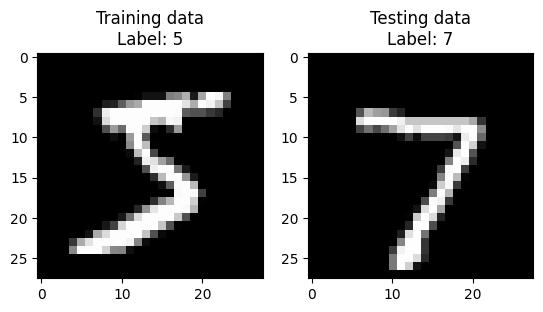

In [6]:
data_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

mnist_train = torchvision.datasets.MNIST(root='./temp', train=True, transform=data_transform, download=True)
mnist_test = torchvision.datasets.MNIST(root='./temp', train=False, transform=data_transform, download=True)

plt.subplot(1, 2, 1)
plt.imshow(mnist_train.data[0].numpy(), cmap='gray')
plt.title(f"Training data\nLabel: {mnist_train.targets[0]}")

plt.subplot(1, 2, 2)
plt.imshow(mnist_test.data[0].numpy(), cmap='gray')
plt.title(f"Testing data\nLabel: {mnist_test.targets[0]}")
plt.show()

In [7]:
classes = torch.arange(0, len(mnist_train.classes))
mt = mytorch(classes=classes)

StandardScaler_ = StandardScaler()
data_index_max = 200

X_train = StandardScaler_.fit_transform(mnist_train.data.to(torch.float32))
X_train = X_train.to("cuda")
y_train = mnist_train.targets.to("cuda")

X_test = StandardScaler_.transform(mnist_test.data[0:data_index_max].to(torch.float32))
X_test = X_test.to("cuda")
y_test = mnist_test.targets[0:data_index_max].to("cuda")

In [8]:
mt.build_conv_2d(1, 2, 2)
mt.build_sigmoid()
mt.build_conv_2d(2, 3, 3)
mt.build_tanh()
mt.build_MeanPool_2d(3, 2)
mt.build_flatten()
mt.build_NN(432, 256)
mt.build_sigmoid()
mt.build_NN(256, 32)
mt.build_tanh()
mt.build_NN(32, 10)
mt.build_sigmoid()

In [9]:
mt.pred(X_train[0], return_probability=True)

(tensor(8, device='cuda:0'),
 tensor([1.5994e-05, 1.6710e-01, 3.6331e-01, 4.2281e-01, 2.1462e-02, 9.9253e-01,
         9.8592e-01, 9.5591e-01, 9.9474e-01, 9.8488e-01], device='cuda:0'))

In [10]:
mt.build_train(loss_fn="MSE", optimizer="GD", learning_rate=0.5)

In [11]:
loss = np.zeros((1, 10))
epoch = 500
loop = tqdm(range(epoch))

for e in enumerate(loop):
    loss_ = np.zeros((1, 10))
    stochastic = np.random.randint(0, len(X_train), 10)
    
    for i in stochastic:
        pred = mt.pred(X_train[i])
        mt.train(y_train[i])
        loss_ += np.array([mt.loss.cpu().numpy()])
        
    loss = np.append(loss, loss_/10, axis=0)
    loop.set_postfix(train_loss=str(np.average(loss[-1])))
loss = np.delete(loss, 0, axis=0)

100%|██████████| 500/500 [1:16:18<00:00,  9.16s/it, train_loss=0.006453702347078498] 


In [12]:
from sklearn.metrics import accuracy_score

y_pred = np.array([])
for i in range(len(X_train[0:200])):
    y_pred = np.append(y_pred, mt.pred(X_train[i]).cpu().numpy())

y = y_train.cpu().numpy()

acc = accuracy_score(y[0:200], y_pred)
print("train acc:", acc*100, "%")

train acc: 82.0 %


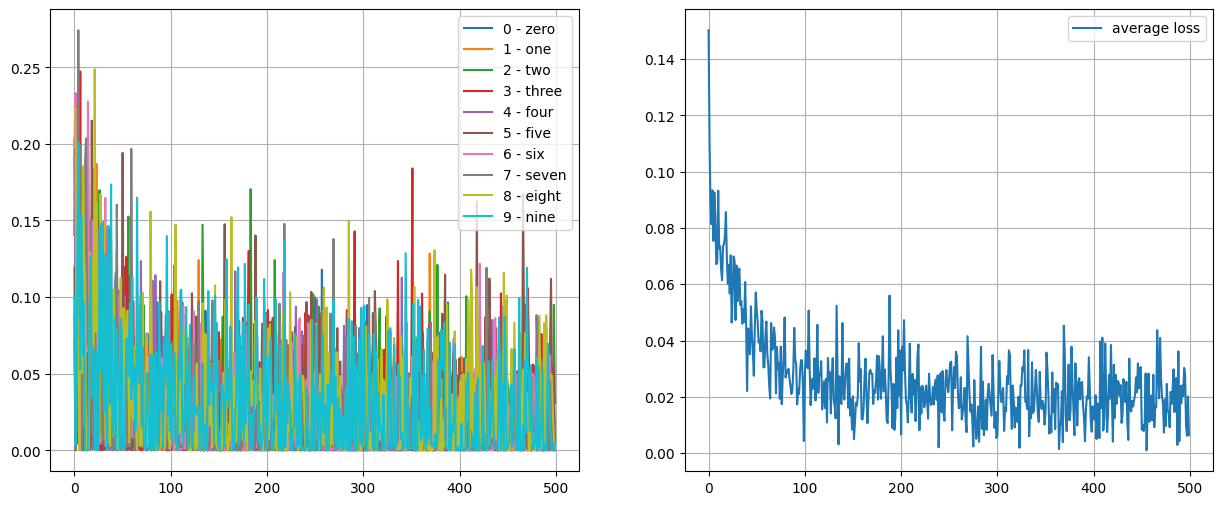

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(range(epoch), loss)
plt.legend(mnist_train.classes)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epoch), np.average(loss, axis=1))
plt.legend(["average loss"])
plt.grid()
plt.show()

In [14]:
y_pred = np.array([])
for i in range(len(X_test)):
    y_pred = np.append(y_pred, mt.pred(X_test[i]).cpu().numpy())

In [15]:
y = y_test.cpu().numpy()

acc = accuracy_score(y, y_pred)
print("test acc:", acc*100, "%")

test acc: 84.0 %
